In [1]:
%matplotlib notebook
%matplotlib inline
import math
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import matplotlib.cm as cm
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["image.cmap"] = 'hsv'
plt.rcParams["animation.embed_limit"] = 1866

In [2]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and, given raw input images as PIL images,
 |  returns images cropped to include the face only. Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the davidsandberg/facenet
 |          repo, which applies the margin to the original image before resizing, making the margin
 |          dependent on the original image size (this is a b

In [2]:
def video_read(video_path):
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    buf = np.empty((frame_count, frame_height, frame_width, 3), np.dtype('uint8'))
    fc = 0
    ret = True
    while fc < frame_count and ret:
        ret, frame = video.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            buf[fc] = frame
            fc += 1
    video.release()
    return fc, buf

In [3]:
def video_write(buf, out_path):
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (buf.shape[2], buf.shape[1]), 0)
    for frame in buf:
        out.write(frame)
    out.release()
    print('done - ' + out_path)

In [4]:
def draw_videos(videos_cols, columns_color_maps, columns_titles, fc):
    cols = len(videos_cols)
    rows = max(map(lambda col: len(col), videos_cols))
    fig, ax = plt.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(10 * cols, 10 * rows))
    #TO CHECK
    im = [[ax[j, i].imshow(video[0], cmap=columns_color_maps[i], animated=True)
           for j, video in enumerate(col)] 
          for i, col in enumerate(videos_cols)]      
    for i, title in enumerate(columns_titles): ax[0][i].title.set_text(title)
    def draw(frame_count):
        # TO CHECK
        [im[i][j].set_data(video[frame_count])
         for i, col in enumerate(videos_cols)
         for j, video in enumerate(col)]
    ani = animation.FuncAnimation(fig, draw, interval=30, save_count=fc)
    return ani

In [5]:
def detect_faces(video, device):
    mtcnn = MTCNN(keep_all=True, select_largest=False, post_process=True, device=device)
    return [mtcnn.detect(Image.fromarray(frame)) for frame in video]

In [6]:
def get_face_info(segments):
    total_probability_threshold = 0.5
    faces = []
    def insert_info(info, frame_num, rect, proba):
        info["last_frame"] = frame_num
        info["widths"][frame_num] = rect[2] - rect[0]
        info["heights"][frame_num] = rect[3] - rect[1]
        info["centers_x"][frame_num] = rect[0] + (info["widths"][frame_num] / 2)
        info["centers_y"][frame_num] = rect[1] + (info["heights"][frame_num] / 2)
        info["probs"][frame_num] = proba
    for frame_num, frame_segment in enumerate(segments):
        for rect, prob in zip(frame_segment[0], frame_segment[1]):
            matched = False
            for face_info in faces:
                last_frame = face_info["last_frame"]
                if last_frame < frame_num:
                    if rect[0] < face_info["centers_x"][last_frame] < rect[2] \
                    and rect[1] < face_info["centers_y"][last_frame] < rect[3]:
                        insert_info(face_info, frame_num, rect, prob)
                        matched = True
                        break
            if not matched:
                face_info = {
                    "last_frame": 0,
                    "centers_x": np.zeros(len(segments), dtype='float32'),
                    "centers_y": np.zeros(len(segments), dtype='float32'),
                    "widths": np.zeros(len(segments), dtype='float32'),
                    "heights": np.zeros(len(segments), dtype='float32'),
                    "probs": np.zeros(len(segments), dtype='float32')
                }
                faces.append(face_info)
                insert_info(face_info, frame_num, rect, prob)
    faces = list(filter(lambda face: np.mean(face["probs"]) > total_probability_threshold, faces))
    def interp_array(arr):
        l = len(arr)
        fp = arr[arr > 0]
        xp = (arr > 0) * (np.arange(l) + 1) 
        xp = xp[xp > 0] - 1
        return np.interp(np.arange(l), xp, fp)
    for face in faces:
        face["centers_x"] = interp_array(face["centers_x"])
        face["centers_y"] = interp_array(face["centers_y"])
    return faces

In [7]:
def read_metadata(path):
    metadata_file = open(path)
    metadata = json.load(metadata_file)
    metadata_file.close()
    return metadata

In [8]:
def write_metadata(metadata, path):
    with open(path, 'w') as output:
        json.dump(metadata, output)

In [9]:
dir = "D:\\Projects\\DFDC\\Data\\"
metadata_file_name = 'metadata.json'

metadata = read_metadata(dir + metadata_file_name)

In [10]:
video_name = 'abzcmncrxu.mp4'
video_info = metadata[video_name]
video_sub_dir = video_info['dir']
if video_info['label'] == 'FAKE':
    fake_names = [video_name]
    real_name = video_info['original']
elif video_info['label'] == 'REAL':
    real_name = video_name
    fake_names = video_info['fakes']
else:
    real_name = video_name
    fake_names = []
print("Original Video: {0}".format(real_name))
print("Fake Videos: {0}".format(fake_names))
fake_order = 0

real_fc, real_video = video_read("{}{}\\{}".format(dir, video_sub_dir, real_name))
fake_fc, fake_video = video_read("{}{}\\{}".format(dir, video_sub_dir, fake_names[fake_order]))
fc = min(real_fc, fake_fc)
real_video = real_video[:fc]
fake_video = fake_video[:fc]
print("Number of frames: {0}".format(fc))

Original Video: hmpbhblarx.mp4
Fake Videos: ['abzcmncrxu.mp4']
Number of frames: 300


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [12]:
segments = detect_faces(real_video, device)

In [13]:
faces = get_face_info(segments)
print('Found {} faces in video'.format(len(faces)))

Found 2 faces in video


In [14]:
size = 300
video_height = real_video.shape[1]
video_width = real_video.shape[2]
def top(y):
    return 0 if y < size / 2 else video_height - size if y + (size / 2) > video_height else int(y - (size / 2))
def bottom(y):
    return size if y < size / 2 else video_height if y + (size / 2) > video_height else int(y + (size / 2))
def left(x):
    return 0 if x < size / 2 else video_width - size if x + (size / 2) > video_width else int(x - (size / 2))
def right(x):
    return size if x < size / 2 else video_width if x + (size / 2) > video_width else int(x + (size / 2))
faces_crops = [[(frame, top(y), bottom(y), left(x), right(x))
         for frame, (x, y) in enumerate(zip(face["centers_x"], face["centers_y"]))]
         for face in faces]
real_face_video = np.stack(
    [np.stack(
        [real_video[frame, top:bottom, left:right, :] for frame, top, bottom, left, right in crops]
    ) for crops in faces_crops])
fake_face_video = np.stack(
    [np.stack(
        [fake_video[frame, top:bottom, left:right, :] for frame, top, bottom, left, right in crops]
    ) for crops in faces_crops])

In [15]:
diff = np.sqrt(np.sum(np.square(np.subtract(real_face_video, fake_face_video)), axis=4))

In [16]:
diff_min = np.min(diff)
print("Diff min: {0}".format(diff_min))
diff_max = np.max(diff)
print("Diff max: {0}".format(diff_max))

Diff min: 0.0
Diff max: 27.331300737432898


In [17]:
top_percentage = 5
threshold = np.percentile(diff, 100 - (top_percentage / diff.shape[0]))
print("Threshold: {0}".format(threshold))

Threshold: 12.767145334803704


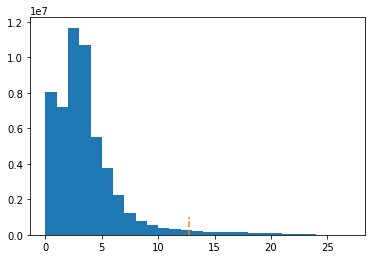

In [18]:
plt.hist(diff.flatten(), bins=range(math.ceil(diff_max)))
plt.plot([threshold, threshold], [0, 1000000], linestyle='--', scalex=False)
plt.show()

In [19]:
gray_diff = (diff - diff_min) * (255 / (diff_max - diff_min))
gray_threshold = (threshold - diff_min) * (255 / (diff_max - diff_min))

In [20]:
mask = gray_diff > gray_threshold
filtered_diff = gray_diff * mask

In [21]:
combined = [[real_face_video, filtered_diff, fake_face_video]]
test = [video.shape
for i, row in enumerate(combined) 
for j, video in enumerate(row)]

In [22]:
%%capture
diff_ani = draw_videos([real_face_video, filtered_diff, fake_face_video], [cm.viridis, cm.gray, cm.viridis], ["Original", "Diff", "Fake"], fc)
# diff_ani = draw_videos([real_face_video, filtered_diff], [cm.viridis, cm.gray], ["Original", "Diff"], fc)

In [ ]:
diff_ani